## Benchmark: ARIMA

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MSE, MAE, MAPE
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import os
import sys
import platform
if platform.node() in ['msbq']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data, get_fx_and_metric_data_wo_weekend, mde

Functions

In [14]:
def actual_pred_plot(preds, y_test):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['prediction'] = preds[:,0]
    actual_pred['Adj. Close'] = y_test[:,0]  #.loc['2019':,'Adj Close'][0:len(preds)]

    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    return (m.result().numpy(), actual_pred.plot() )

### Data

In [15]:
df = get_fx_and_metric_data_wo_weekend(dtype=np.float32)

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Create training and test data

In [16]:
def ts_train_test_normalize(df,time_steps,for_periods, target_column=1):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2020/11/2-2020/12/31
      X_test:  data from 2021 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''    # create training and test set
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

    ts_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
    index_train = df[df.index < last_20pct].index
    ts_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
    index_val = df[(df.index >= last_20pct) & (df.index < last_10pct)].index
    ts_test = df[(df.index >= last_10pct)]
    index_test = df[(df.index >= last_10pct)].index

    ts_train_len = len(ts_train)
    ts_val_len = len(ts_test)
    ts_test_len = len(ts_test)

    '''Normalize price columns'''
    #   df = (df - df.mean()) / (df.max() - df.min())
    #   df.columns[np.isnan(df).any(axis=0)]
    
    # sc = MinMaxScaler((-1, 1)).fit(ts_train)
    sc = StandardScaler().fit(ts_train)
    sc_target = StandardScaler().fit(ts_train.iloc[:, target_column:target_column+1])
    
    ts_train_scaled = ts_train.values  # sc.transform(ts_train)
    ts_val_scaled = ts_val.values  # sc.transform(ts_val)
    ts_test_scaled = ts_test.values  # sc.transform(ts_test)
    
    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i])
        y_train.append(ts_train_scaled[i:i+for_periods, target_column])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_val = []
    y_val = []
    y_val_stacked = []
    for i in range(time_steps,ts_val_len-1): 
        X_val.append(ts_val_scaled[i-time_steps:i])
        y_val.append(ts_val_scaled[i:i+for_periods,target_column])
    X_val, y_val = np.array(X_val), np.array(y_val)
    # Reshaping X_train for efficient modelling
    #     X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    # Preparing X_test
    X_test = []
    y_test = []
    for i in range(time_steps,ts_test_len-for_periods):
        X_test.append(ts_test_scaled[i-time_steps:i])
        y_test.append(ts_test_scaled[i:i+for_periods,target_column])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    #     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test


In [17]:
target_column = list(df.columns).index('EURUSD BGNE Curncy Bid Close')
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test =\
    ts_train_test_normalize(df, 1, 1, target_column)

In [19]:
# X_train.tofile('Benchmark/X_train.csv', sep='/n)
# X_test.('Benchmark/X_test.csv', sep='/n')
np.savetxt('Benchmark/ARIMA_GARCH/X_test.csv', X_test[:, 0, target_column].reshape(-1, 1))
np.savetxt('Benchmark/ARIMA_GARCH/X_val.csv', X_val[:, 0, target_column].reshape(-1, 1))
np.savetxt('Benchmark/ARIMA_GARCH/X_train.csv', X_train[:, 0, target_column].reshape(-1, 1))

# X_test[:, 0, target_column].shape

# pd.DataFrame(X_test[:100, 0, target_column].reshape(-1, 1)).to_csv('Benchmark/X_test2.csv')

## ARMA-GARCH


In [20]:
y_train_pred = pd.read_csv('Benchmark/ARIMA_GARCH/X_train_forecast.csv').to_numpy()
y_val_pred = pd.read_csv('Benchmark/ARIMA_GARCH/X_val_forecast.csv').to_numpy()
y_test_pred = pd.read_csv('Benchmark/ARIMA_GARCH/X_test_forecast.csv').to_numpy()

In [21]:
print(y_train_pred.shape)
print(y_val_pred.shape)
print(y_test_pred.shape)

(23208, 2)
(2899, 2)
(2899, 2)


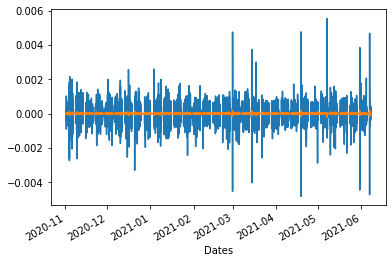

In [22]:
pd.Series(
    data=y_train[:, 0],
    index=index_train[-y_train_pred.shape[0]:],
).plot()
pd.Series(
    data=y_train_pred[:,0],
    index=index_train[-y_train_pred.shape[0]:],
).plot()
# plt.ylim(m_min, m_max)
plt.show()

In [23]:
y_pred_error = pd.Series(
    data=y_train_pred[:, 0].flatten() - y_train.flatten(),
    index=index_train[-y_train_pred.shape[0]:],
).iloc[1:]

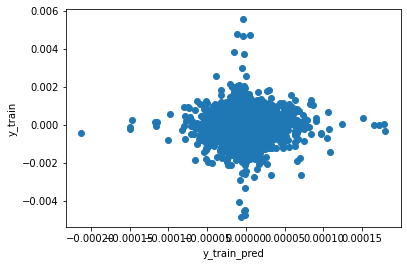

Text(0.5, 1.0, 'QQ-lot for y_train_pred - y_train')

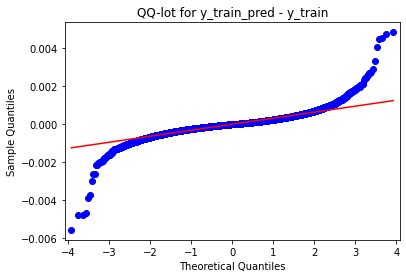

In [24]:
# y_pred_error.plot()
# plt.show()
plt.scatter(y_train_pred[1:, 0], y_train[1:])
plt.xlabel('y_train_pred')
plt.ylabel('y_train')
plt.show()
import statsmodels.api as smi
smi.qqplot(y_pred_error[1:], line = "r")
plt.title('QQ-lot for y_train_pred - y_train')
# pylab.show()

In [25]:
y = y_train
y_pred = y_train_pred[:, 0]
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')

mse: 1.1344402176698928e-07
mae: 0.0002196127884909987
mape: 265.3501623735314
mde: 0.24797164770031255


In [26]:
y = y_val
y_pred = y_val_pred[:, 0]
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')

mse: 9.232133522921725e-08
mae: 0.00019787120767345107
mape: 224.49597393675322
mde: 0.2420669451005215


Get model for test data.

In [27]:
y = y_test
y_pred = y_test_pred[:, 0]
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')

mse: 7.685756302929351e-08
mae: 0.00018871551589661254
mape: 207.4922076027666
mde: 0.24810011521236652
